In [1]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
train_set = pd.read_csv("../project2_TS_input/ptbdb_train.csv", header=None)
test_set = pd.read_csv("../project2_TS_input/ptbdb_test.csv", header=None)

In [3]:
y_train=train_set.iloc[:,-1]
X_train = train_set.iloc[:,:-1]
y_test=test_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]

In [4]:
X_train_tensor = torch.tensor(X_train.values , dtype=torch.float)
y_train_tensor= torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values , dtype=torch.float)
y_test_tensor= torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for each dataset
batch_size = 128
loader_train = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
loader_test = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=2911, shuffle=False)
loader_valid = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)

# Vanilla simple CNN

In [6]:
class ConvUnit(nn.Module):
    def __init__(self, unit):
        super(ConvUnit, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv_units = nn.ModuleList([ConvUnit(i+1) for i in range(5)])
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# train the model
def train(model, criterion, optimizer, train_loader, epochs=5, plot = True):
    '''
    Train the network and validate it at each epoch plotting the training and validation loss curves
    '''
    train_losses = []


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for timeseries, labels in tqdm(train_loader):
            timeseries, labels = timeseries.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(timeseries)
            labels = labels.float()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0

        print(f"Epoch {epoch + 1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}")

    if plot:
        plt.plot(train_losses, label='Training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_losses


100%|██████████| 91/91 [00:19<00:00,  4.59it/s]


Epoch 1/10.. Train loss: 0.564


100%|██████████| 91/91 [00:21<00:00,  4.32it/s]


Epoch 2/10.. Train loss: 0.419


100%|██████████| 91/91 [00:21<00:00,  4.14it/s]


Epoch 3/10.. Train loss: 0.378


100%|██████████| 91/91 [00:22<00:00,  4.09it/s]


Epoch 4/10.. Train loss: 0.343


100%|██████████| 91/91 [00:20<00:00,  4.48it/s]


Epoch 5/10.. Train loss: 0.291


100%|██████████| 91/91 [00:21<00:00,  4.32it/s]


Epoch 6/10.. Train loss: 0.228


100%|██████████| 91/91 [00:17<00:00,  5.14it/s]


Epoch 7/10.. Train loss: 0.176


100%|██████████| 91/91 [00:14<00:00,  6.08it/s]


Epoch 8/10.. Train loss: 0.143


100%|██████████| 91/91 [00:15<00:00,  5.85it/s]


Epoch 9/10.. Train loss: 0.126


100%|██████████| 91/91 [00:15<00:00,  5.92it/s]


Epoch 10/10.. Train loss: 0.110


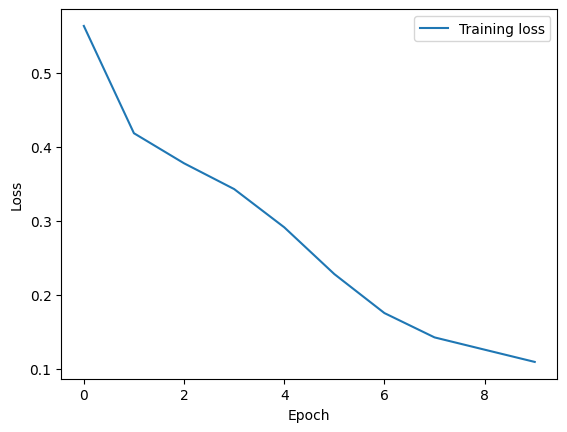

In [13]:
train_losses= train(model, criterion, optimizer, loader_train, epochs=10)

In [21]:
save_model = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer
}

torch.save(save_model, 'checkpoints/Part1_Q3_VanillaCNN_complex_.pth')

In [13]:
# Evaluate the model on the test set

def evaluate(model, test_loader):
    '''
    Evaluate the model on the test set
    '''
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for timeseries, labels in test_loader:
            timeseries, labels = timeseries.to(device), labels.to(device)
            output = model(timeseries)
            labels = labels.float()
            loss = criterion(output, labels)
            test_loss += loss.item()
            preds = torch.round(torch.sigmoid(output))
            correct += (preds == labels).sum().item()
            
            test_loss /= len(test_loader)
            accuracy = correct / len(test_loader.dataset)

            print(f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")

            cm = ConfusionMatrixDisplay.from_predictions(y_test, preds.numpy(), 
                                                    display_labels=['Class 0', 'Class 1'], 
                                                    cmap='Blues', 
                                                    normalize=None)

            print(classification_report(y_test, preds.numpy()))
            print("F1: ",f1_score(y_test, preds.numpy()))

    
    
    return test_loss, accuracy




Test loss: 0.114.. Test accuracy: 0.958
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       809
         1.0       0.97      0.97      0.97      2102

    accuracy                           0.96      2911
   macro avg       0.95      0.95      0.95      2911
weighted avg       0.96      0.96      0.96      2911

F1:  0.9711836151464635


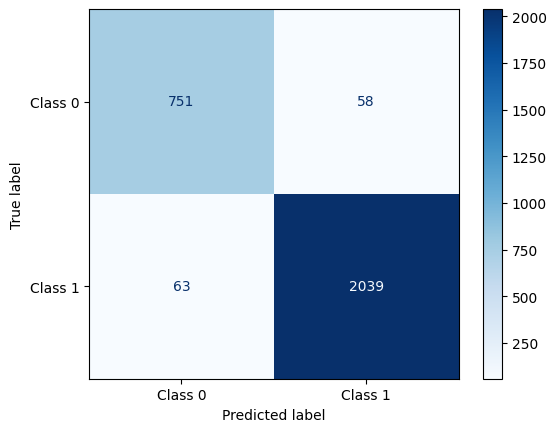

In [23]:
test_loss, test_accuracy = evaluate(model, loader_test)

# Recurrent blocks CNN

In [7]:
class ConvUnitR(nn.Module):
    def __init__(self, unit):
        super(ConvUnitR, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x_add = x
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = x + x_add
        x = nn.functional.relu(x)
        x = self.maxpool(x)
        return x

class CNN_Recurrent(nn.Module):
    def __init__(self):
        super(CNN_Recurrent, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv_units = nn.ModuleList([ConvUnitR(i+1) for i in range(5)])
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        for conv_unit in self.conv_units:
            x = conv_unit(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model_recurrent = CNN_Recurrent().to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_recurrent = optim.Adam(model_recurrent.parameters(), lr=0.001)

100%|██████████| 91/91 [00:15<00:00,  6.00it/s]


Epoch 1/10.. Train loss: 0.499


100%|██████████| 91/91 [00:15<00:00,  5.90it/s]


Epoch 2/10.. Train loss: 0.309


100%|██████████| 91/91 [00:14<00:00,  6.28it/s]


Epoch 3/10.. Train loss: 0.193


100%|██████████| 91/91 [00:15<00:00,  5.99it/s]


Epoch 4/10.. Train loss: 0.142


100%|██████████| 91/91 [00:14<00:00,  6.15it/s]


Epoch 5/10.. Train loss: 0.101


100%|██████████| 91/91 [00:14<00:00,  6.28it/s]


Epoch 6/10.. Train loss: 0.092


100%|██████████| 91/91 [00:15<00:00,  6.06it/s]


Epoch 7/10.. Train loss: 0.076


100%|██████████| 91/91 [00:14<00:00,  6.14it/s]


Epoch 8/10.. Train loss: 0.055


100%|██████████| 91/91 [00:14<00:00,  6.18it/s]


Epoch 9/10.. Train loss: 0.060


100%|██████████| 91/91 [00:14<00:00,  6.21it/s]


Epoch 10/10.. Train loss: 0.049


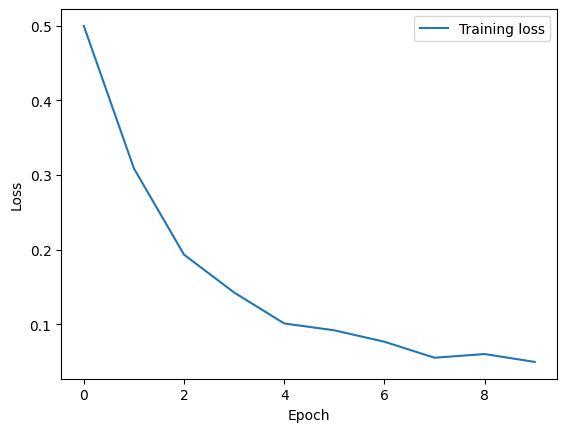

In [14]:
train_losses= train(model_recurrent, criterion, optimizer_recurrent, loader_train, epochs=10)

Test loss: 0.064.. Test accuracy: 0.981
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       809
         1.0       0.99      0.99      0.99      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.98      0.98      2911
weighted avg       0.98      0.98      0.98      2911

F1:  0.9866666666666666


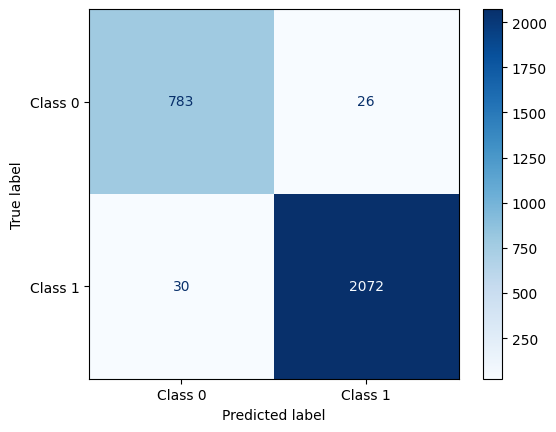

In [15]:
test_loss, test_accuracy = evaluate(model_recurrent, loader_test)

In [16]:
save_model = {
    'state_dict': model_recurrent.state_dict(),
    'optimizer' : optimizer_recurrent
}

torch.save(save_model, 'checkpoints/Part1_Q3_RecurrentCNN_complex_.pth')